# Dubinska analiza podataka - projektni zadatak

## 1. Predprocesiranje podataka

In [48]:
phoneData <- read.csv('phone_specs.csv')

str(phoneData)

'data.frame':	1359 obs. of  22 variables:
 $ Index          : int  0 1 2 3 4 5 6 7 8 9 ...
 $ Name           : chr  "OnePlus 7T Pro McLaren Edition" "Realme X2 Pro" "iPhone 11 Pro Max" "iPhone 11" ...
 $ Brand          : chr  "OnePlus" "Realme" "Apple" "Apple" ...
 $ Model          : chr  "7T Pro McLaren Edition" "X2 Pro" "iPhone 11 Pro Max" "iPhone 11" ...
 $ BatteryCapacity: int  4085 4000 3969 3110 4000 3800 4085 4300 6000 4000 ...
 $ ScreenSize     : num  6.67 6.5 6.5 6.1 6.4 6.55 6.67 6.8 6.59 6.39 ...
 $ Touchscreen    : chr  "Yes" "Yes" "Yes" "Yes" ...
 $ ResolutionX    : int  1440 1080 1242 828 1080 1080 1440 1440 1080 1080 ...
 $ ResolutionY    : int  3120 2400 2688 1792 2340 2400 3120 3040 2340 2340 ...
 $ Processor      : int  8 8 6 6 8 8 8 8 8 8 ...
 $ RAM            : int  12000 6000 4000 4000 6000 8000 8000 12000 8000 6000 ...
 $ InternalStorage: num  256 64 64 64 128 128 256 256 128 128 ...
 $ RearCamera     : num  48 64 12 12 12 48 48 12 48 48 ...
 $ FrontCamera    : nu

In [40]:
table(phoneData$OS)


   Android BlackBerry   Cyanogen        iOS   Sailfish      Tizen    Windows 
      1299         10         10         17          1          3         19 

In [49]:
library(tidyr)
library(dplyr)

phoneData <- phoneData %>%
    filter(!(OS == 'Sailfish' | OS == 'Tizen' |
            OS == 'Cyanogen' | OS == 'BlackBerry')) %>%                       # delete rows with less know OS (only 24 rows)
    mutate(across(c(Touchscreen, WiFi, Bluetooth, GPS, X3G, X4G.LTE),
          ~as.numeric(ifelse(.x == 'Yes', 1, 0)))) %>%                        # convert categorical Yes/No to 1/0
    mutate(value = 1) %>% spread(OS, value,  fill = 0 ) %>%                   # One-hot-encoding OS column
    mutate(across(c(5,6, 8:14, 18), scale)) %>%                               # normalization with scale() for numeric data
    mutate(Price=round(Price/87.95)) %>%                                      # convert indian rupee to euro
    mutate(PriceCategory = ifelse(Price <= 60, 'Low-End', ifelse(Price <= 110, 'Mid-Range', 'High-End')))

In [50]:
#phoneData <- phoneData[ -c(1:4,7,15:17,19:21) ]

phoneData <- phoneData[ -c(1:4,21) ]
phoneData$PriceCategory <- factor(phoneData$PriceCategory, levels = c('Low-End', 'Mid-Range', 'High-End'), ordered=T)

In [51]:
table(phoneData$PriceCategory)


  Low-End Mid-Range  High-End 
      438       454       443 

## 2. Klasifikacija - umjetne neuronske mreže

In [52]:
library(neuralnet)
library(caret)

indeksi = createDataPartition(phoneData$PriceCategory, p = 0.8, list = FALSE)
skup_tren <- phoneData[indeksi, ]
skup_test <- phoneData[-indeksi, ] 

nn = neuralnet(PriceCategory ~ .,
                data = skup_tren,
                hidden = 10,
                lifesign = 'full',
                linear.output = FALSE,
                stepmax = 1000000)

hidden: 10    thresh: 0.01    rep: 1/1    steps: 
   1000	min thresh: 0.200132883705957
                                                 
   2000	min thresh: 0.117631776248658
                                                 
   3000	min thresh: 0.0659059806016966
                                                 
   4000	min thresh: 0.0521816805438491
                                                 
   5000	min thresh: 0.0488642232827096
                                                 
   6000	min thresh: 0.0488642232827096
                                                 
   7000	min thresh: 0.0488642232827096
                                                 
   8000	min thresh: 0.0488642232827096
                                                 
   9000	min thresh: 0.0488642232827096
                                                 
  10000	min thresh: 0.047639347170127
                                                 
  11000	min thresh: 0.0441342666930026
                        

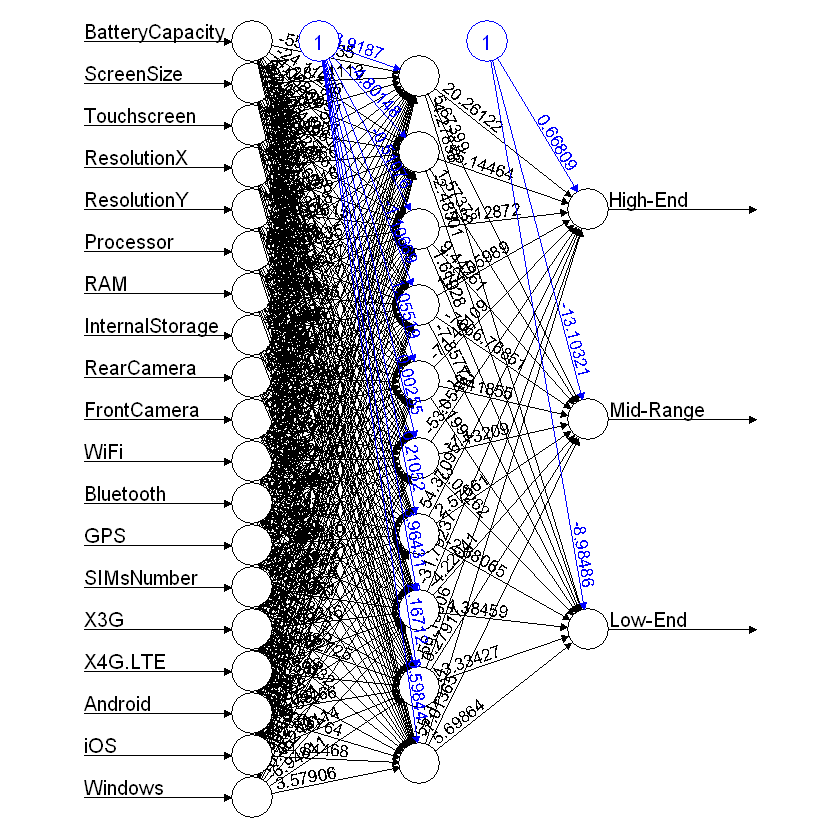

In [53]:
plot(nn, rep=1)

In [54]:
names(phoneData)

[1] "BatteryCapacity" "ScreenSize"      "Touchscreen"     "ResolutionX"    
 [5] "ResolutionY"     "Processor"       "RAM"             "InternalStorage"
 [9] "RearCamera"      "FrontCamera"     "WiFi"            "Bluetooth"      
[13] "GPS"             "SIMsNumber"      "X3G"             "X4G.LTE"        
[17] "Android"         "iOS"             "Windows"         "PriceCategory"

In [55]:
predikcije <- neuralnet::compute(nn, rep = 1, skup_test[,-20])  # -14

yhat <- predikcije$net.result

print(yhat)

yhat <- data.frame("yhat"=ifelse(max.col(yhat[ ,1:3])==1, "High-End",
                          ifelse(max.col(yhat[ ,1:3])==2, "Mid-Range", "Low-End")))

print(yhat)

             [,1]          [,2]         [,3]
8    1.000000e+00  0.000000e+00 9.371454e-10
11   1.000000e+00  0.000000e+00 1.211445e-08
21   1.000000e+00  0.000000e+00 9.026294e-07
40   1.000000e+00  0.000000e+00 7.619777e-04
43   1.000000e+00  0.000000e+00 1.841524e-05
49   1.000000e+00  0.000000e+00 3.376026e-08
52   1.000000e+00  0.000000e+00 4.764638e-05
63   2.811148e-08  5.500405e-02 5.716256e-01
68   1.000000e+00  0.000000e+00 7.429380e-05
69   6.853438e-01  1.916955e-34 4.942767e-01
80   1.000000e+00  0.000000e+00 1.849518e-02
83   1.000000e+00  0.000000e+00 1.319044e-02
92   1.000000e+00  0.000000e+00 6.690406e-05
106  9.529574e-01  2.352983e-16 1.883930e-01
109  5.742520e-13  5.103466e-06 7.958968e-01
110  1.000000e+00  0.000000e+00 1.590456e-03
111  6.488767e-11  5.326961e-62 9.761519e-01
121  9.999697e-01 7.859768e-194 3.234874e-02
133  3.229086e-05  9.458757e-03 3.561748e-01
136  1.000000e+00  4.355788e-05 6.158980e-02
139  1.000000e+00  0.000000e+00 8.103497e-07
140  3.219

#### Točnost 40%

In [56]:
cm <- confusionMatrix(skup_test$PriceCategory, factor(yhat$yhat, levels = c('Low-End', 'Mid-Range', 'High-End'), ordered=T))
 
print(cm)

Confusion Matrix and Statistics

           Reference
Prediction  Low-End Mid-Range High-End
  Low-End        25        56        6
  Mid-Range      45        25       20
  High-End       24         7       57

Overall Statistics
                                          
               Accuracy : 0.4038          
                 95% CI : (0.3442, 0.4655)
    No Information Rate : 0.3547          
    P-Value [Acc > NIR] : 0.0552157       
                                          
                  Kappa : 0.1058          
                                          
 Mcnemar's Test P-Value : 0.0003892       

Statistics by Class:

                     Class: Low-End Class: Mid-Range Class: High-End
Sensitivity                 0.26596          0.28409          0.6867
Specificity                 0.63743          0.63277          0.8297
Pos Pred Value              0.28736          0.27778          0.6477
Neg Pred Value              0.61236          0.64000          0.8531
Prevalence     

## 3. Ansambli - slučajne šume

## 4. Asocijacijska analiza - učenje asocijacijskih pravila

## 5. Grupiranje k-sredina